# Transformers显存优化

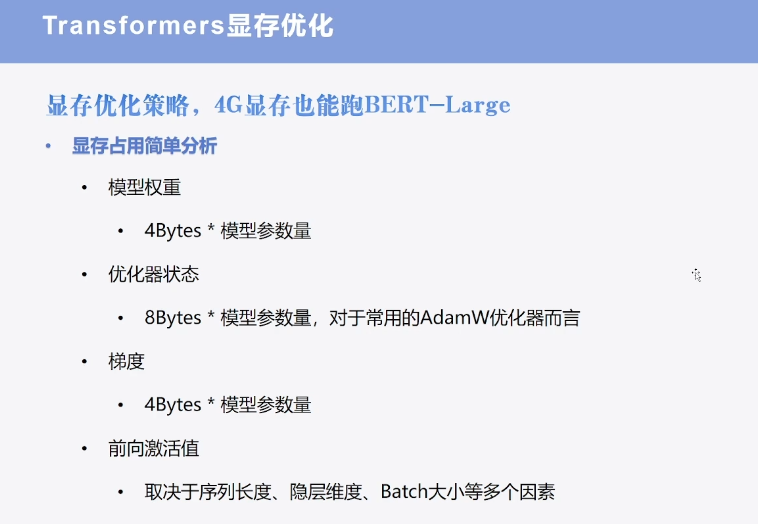

# 文本分类实例

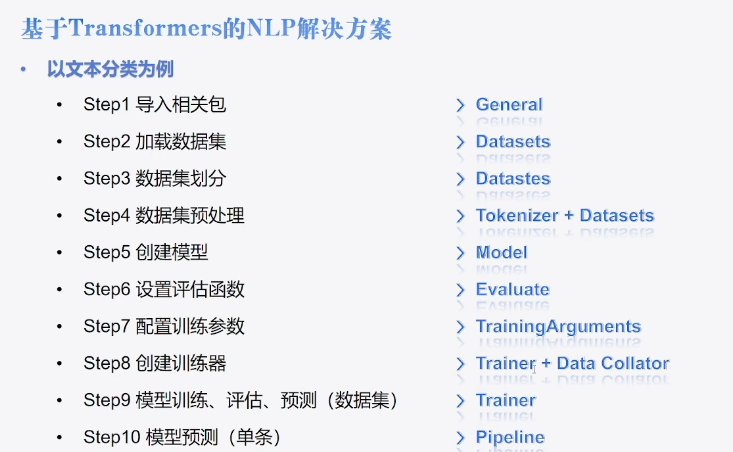

step 1 导入相关的包

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset

step 2 加载数据

In [4]:
dataset = load_dataset("csv", data_files="./ChnSentiCorp_htl_all.csv", split="train")
dataset = dataset.filter(lambda x : x["review"] is not None)
dataset

Dataset({
    features: ['label', 'review'],
    num_rows: 7765
})

step 3 划分数据集

In [5]:
datasets = dataset.train_test_split(test_size=0.1, train_size=0.9)
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'review'],
        num_rows: 6988
    })
    test: Dataset({
        features: ['label', 'review'],
        num_rows: 777
    })
})

step 4 数据集预处理

In [6]:
import torch

tokenizer = AutoTokenizer.from_pretrained("hfl_chinese_macbert")

def process_func(examples):
    tokenized_examples = tokenizer(examples["review"], max_length=128, truncation=True)
    tokenized_examples["labels"] = examples["label"]
    return tokenized_examples

tokenized_datasets = datasets.map(process_func, batched=True, remove_columns=datasets["train"].column_names)
tokenized_datasets

Map:   0%|          | 0/6988 [00:00<?, ? examples/s]

Map:   0%|          | 0/777 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6988
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 777
    })
})

step 5 创建模型

In [8]:
model = AutoModelForSequenceClassification.from_pretrained("hfl_chinese_macbert", ).cuda()

ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

Step6 创建评估函数

In [ ]:
import evaluate

acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

In [ ]:
def eval_metric(eval_predict):
    predictions, labels = eval_predict
    predictions = predictions.argmax(axis=-1)
    acc = acc_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    acc.update(f1)
    return acc

Step7 创建TrainingArguments

In [ ]:
train_args = TrainingArguments(output_dir="./checkpoints",      # 输出文件夹
                               per_device_train_batch_size=64,  # 训练时的batch_size
                               per_device_eval_batch_size=128,  # 验证时的batch_size
                               logging_steps=10,                # log 打印的频率
                               evaluation_strategy="epoch",     # 评估策略
                               save_strategy="epoch",           # 保存策略
                               save_total_limit=3,              # 最大保存数
                               learning_rate=2e-5,              # 学习率
                               weight_decay=0.01,               # weight_decay
                               metric_for_best_model="f1",      # 设定评估指标
                               load_best_model_at_end=True)     # 训练完成后加载最优模型
train_args

Step8 创建Trainer

In [ ]:
from transformers import DataCollatorWithPadding
trainer = Trainer(model=model, 
                  args=train_args, 
                  train_dataset=tokenized_datasets["train"], 
                  eval_dataset=tokenized_datasets["test"], 
                  data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
                  compute_metrics=eval_metric)


Step9 模型训练

In [ ]:
trainer.train()

Step10 模型评估

In [ ]:

trainer.evaluate(tokenized_datasets["test"])

Step11 模型预测

In [ ]:
trainer.predict(tokenized_datasets["test"])

In [ ]:
from transformers import pipeline

id2_label = id2_label = {0: "差评！", 1: "好评！"}
model.config.id2label = id2_label
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)
sen = "我觉得不错！"
pipe(sen)